# 04.5c Angular Warping Under Causal Metric

Measure how the causal metric changes angular relationships between tokens.

**Key question:** Does M preserve angles (like uniform scaling), or does it warp the angular structure of token space?

**Method:**
1. Sample random token pairs
2. Compute angle in Euclidean space: `cos(θ_euc) = (v₁·v₂)/(||v₁|| ||v₂||)`
3. Compute angle in causal space: `cos(θ_caus) = (v₁ᵀMv₂)/(||v₁||_M ||v₂||_M)`
4. Measure angular distortion: `Δθ = θ_caus - θ_euc`
5. Visualize distribution

**Interpretation:**
- If Δθ ≈ 0 for all pairs → M preserves angles (conformal transformation)
- If Δθ varies significantly → M warps angular structure (nontrivial geometry)

## Configuration

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from transformers import AutoModelForCausalLM, AutoTokenizer

# Model and paths
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"
METRIC_PATH = Path("../data/vectors/causal_metric_tensor_qwen3_4b.pt")

# Sampling parameters
N_SAMPLES = 10000
RANDOM_SEED = 42

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Plot style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

Using device: mps


## Load Metric Tensor and Model

In [2]:
# Load metric tensor
print("Loading causal metric tensor...")
metric_data = torch.load(METRIC_PATH, map_location=device, weights_only=True)
M = metric_data['M']
print(f"M shape: {M.shape}")
print()

# Load model for gamma matrix
print(f"Loading {MODEL_NAME}...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map=device,
)
model.eval()

# Extract gamma (unembedding matrix)
gamma = model.lm_head.weight.data.to(dtype=torch.float32, device=device)
vocab_size, hidden_dim = gamma.shape
print(f"Gamma shape: {gamma.shape}")
print(f"Vocabulary size: {vocab_size:,} tokens")
print()

# Load tokenizer for decoding
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer loaded.")

Loading causal metric tensor...
M shape: torch.Size([2560, 2560])

Loading Qwen/Qwen3-4B-Instruct-2507...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Gamma shape: torch.Size([151936, 2560])
Vocabulary size: 151,936 tokens

Tokenizer loaded.


## Sample Token Pairs

In [3]:
print(f"Sampling {N_SAMPLES:,} random token pairs...")
torch.manual_seed(RANDOM_SEED)

# Sample random pairs (ensuring i ≠ j)
idx1 = torch.randint(0, vocab_size, (N_SAMPLES,), device=device)
idx2 = torch.randint(0, vocab_size, (N_SAMPLES,), device=device)
mask = idx1 != idx2
idx1 = idx1[mask]
idx2 = idx2[mask]
n_valid = len(idx1)

print(f"Got {n_valid:,} valid pairs (i ≠ j)")
print()

# Extract token vectors
v1 = gamma[idx1]  # [n_valid, hidden_dim]
v2 = gamma[idx2]  # [n_valid, hidden_dim]

Sampling 10,000 random token pairs...
Got 10,000 valid pairs (i ≠ j)



## Compute Euclidean Angles

In [4]:
print("Computing Euclidean angles...")

# Euclidean inner products
dot_products_euc = (v1 * v2).sum(dim=1)  # [n_valid]

# Euclidean norms
norms1_euc = torch.norm(v1, dim=1)  # [n_valid]
norms2_euc = torch.norm(v2, dim=1)  # [n_valid]

# Cosine of angle
cos_theta_euc = dot_products_euc / (norms1_euc * norms2_euc)

# Clamp to [-1, 1] for numerical stability
cos_theta_euc = torch.clamp(cos_theta_euc, -1.0, 1.0)

# Angle in radians
theta_euc = torch.acos(cos_theta_euc)

print(f"Computed {len(theta_euc):,} Euclidean angles.")
print(f"  Mean angle: {theta_euc.mean().item():.4f} rad ({torch.rad2deg(theta_euc.mean()).item():.2f}°)")
print()

Computing Euclidean angles...
Computed 10,000 Euclidean angles.
  Mean angle: 1.4836 rad (85.01°)



## Compute Causal Angles

In [5]:
print("Computing causal angles...")

# Causal inner products: v1^T M v2
# Efficient: (v1 @ M) * v2, then sum
v1_M = v1 @ M  # [n_valid, hidden_dim]
dot_products_caus = (v1_M * v2).sum(dim=1)  # [n_valid]

# Causal norms: sqrt(v^T M v)
norms1_caus_squared = (v1 @ M * v1).sum(dim=1)
norms1_caus = torch.sqrt(torch.clamp(norms1_caus_squared, min=0))

norms2_caus_squared = (v2 @ M * v2).sum(dim=1)
norms2_caus = torch.sqrt(torch.clamp(norms2_caus_squared, min=0))

# Cosine of angle
cos_theta_caus = dot_products_caus / (norms1_caus * norms2_caus)

# Clamp to [-1, 1] for numerical stability
cos_theta_caus = torch.clamp(cos_theta_caus, -1.0, 1.0)

# Angle in radians
theta_caus = torch.acos(cos_theta_caus)

print(f"Computed {len(theta_caus):,} causal angles.")
print(f"  Mean angle: {theta_caus.mean().item():.4f} rad ({torch.rad2deg(theta_caus.mean()).item():.2f}°)")
print()

Computing causal angles...
Computed 10,000 causal angles.
  Mean angle: 1.4083 rad (80.69°)



## Compute Angular Distortion

In [6]:
print("Computing angular distortion...")

# Δθ = θ_causal - θ_euclidean
delta_theta = theta_caus - theta_euc

print(f"Angular Distortion Statistics (Δθ):")
print(f"  Mean:   {delta_theta.mean().item():.6f} rad ({torch.rad2deg(delta_theta.mean()).item():.4f}°)")
print(f"  Median: {delta_theta.median().item():.6f} rad ({torch.rad2deg(delta_theta.median()).item():.4f}°)")
print(f"  Std:    {delta_theta.std().item():.6f} rad ({torch.rad2deg(delta_theta.std()).item():.4f}°)")
print(f"  Min:    {delta_theta.min().item():.6f} rad ({torch.rad2deg(delta_theta.min()).item():.4f}°)")
print(f"  Max:    {delta_theta.max().item():.6f} rad ({torch.rad2deg(delta_theta.max()).item():.4f}°)")
print()

# Coefficient of variation (using absolute values since distortion can be negative)
cv_delta = delta_theta.std().item() / abs(delta_theta.mean().item()) if delta_theta.mean().item() != 0 else float('inf')
print(f"Coefficient of variation: {cv_delta:.4f}")
print()

print("Interpretation:")
if abs(delta_theta.mean().item()) < 0.01:  # < 0.57 degrees
    print("  → Angles nearly preserved (Δθ ≈ 0)")
    print("  → M acts like uniform scaling (conformal)")
elif delta_theta.std().item() < 0.1:  # < 5.7 degrees std
    print(f"  → Consistent angular shift ({torch.rad2deg(delta_theta.mean()).item():.2f}° on average)")
    print("  → M applies systematic rotation/shear")
else:
    print("  → Significant angular warping (large variance)")
    print("  → M has complex geometric structure")

Computing angular distortion...
Angular Distortion Statistics (Δθ):
  Mean:   -0.075325 rad (-4.3158°)
  Median: -0.070660 rad (-4.0485°)
  Std:    0.038478 rad (2.2046°)
  Min:    -0.501055 rad (-28.7083°)
  Max:    0.033457 rad (1.9169°)

Coefficient of variation: 0.5108

Interpretation:
  → Consistent angular shift (-4.32° on average)
  → M applies systematic rotation/shear


## Visualize Angular Relationships

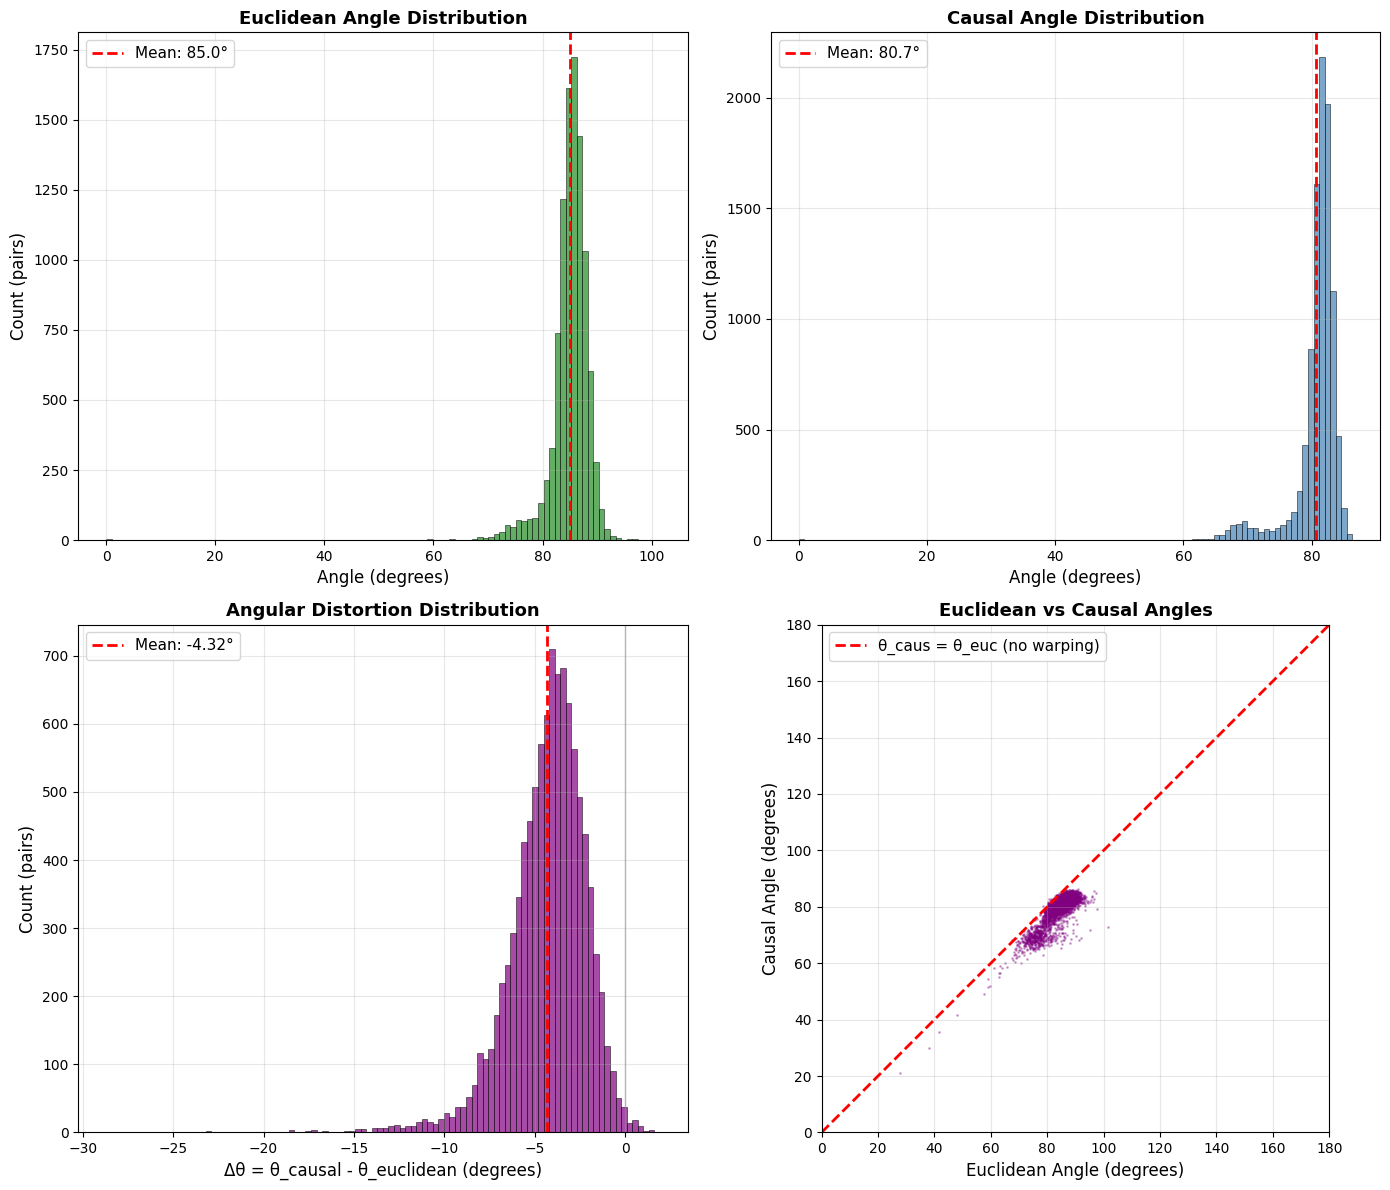


Top left: Euclidean angle distribution
Top right: Causal angle distribution
Bottom left: Angular distortion Δθ
Bottom right: Scatter plot (on diagonal = no warping)


In [7]:
# Convert to numpy for plotting
theta_euc_deg = torch.rad2deg(theta_euc).cpu().numpy()
theta_caus_deg = torch.rad2deg(theta_caus).cpu().numpy()
delta_theta_deg = torch.rad2deg(delta_theta).cpu().numpy()

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Euclidean angle distribution
ax = axes[0, 0]
ax.hist(theta_euc_deg, bins=100, color='forestgreen', alpha=0.7, edgecolor='black', linewidth=0.5)
ax.axvline(theta_euc_deg.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {theta_euc_deg.mean():.1f}°')
ax.set_xlabel('Angle (degrees)', fontsize=12)
ax.set_ylabel('Count (pairs)', fontsize=12)
ax.set_title('Euclidean Angle Distribution', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# 2. Causal angle distribution
ax = axes[0, 1]
ax.hist(theta_caus_deg, bins=100, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
ax.axvline(theta_caus_deg.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {theta_caus_deg.mean():.1f}°')
ax.set_xlabel('Angle (degrees)', fontsize=12)
ax.set_ylabel('Count (pairs)', fontsize=12)
ax.set_title('Causal Angle Distribution', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# 3. Angular distortion distribution
ax = axes[1, 0]
ax.hist(delta_theta_deg, bins=100, color='purple', alpha=0.7, edgecolor='black', linewidth=0.5)
ax.axvline(0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
ax.axvline(delta_theta_deg.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {delta_theta_deg.mean():.2f}°')
ax.set_xlabel('Δθ = θ_causal - θ_euclidean (degrees)', fontsize=12)
ax.set_ylabel('Count (pairs)', fontsize=12)
ax.set_title('Angular Distortion Distribution', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# 4. Scatter: Euclidean vs Causal angles
ax = axes[1, 1]
ax.scatter(theta_euc_deg, theta_caus_deg, alpha=0.3, s=1, color='purple')
ax.plot([0, 180], [0, 180], 'r--', linewidth=2, label='θ_caus = θ_euc (no warping)')
ax.set_xlabel('Euclidean Angle (degrees)', fontsize=12)
ax.set_ylabel('Causal Angle (degrees)', fontsize=12)
ax.set_title('Euclidean vs Causal Angles', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 180)
ax.set_ylim(0, 180)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print("\nTop left: Euclidean angle distribution")
print("Top right: Causal angle distribution")
print("Bottom left: Angular distortion Δθ")
print("Bottom right: Scatter plot (on diagonal = no warping)")

## Find Extreme Distortions

In [8]:
# Find pairs with largest positive and negative distortions
n_extremes = 10

# Sort by distortion
sorted_indices = torch.argsort(delta_theta)

# Most negative (angles became smaller in causal space)
most_negative_indices = sorted_indices[:n_extremes]

# Most positive (angles became larger in causal space)
most_positive_indices = sorted_indices[-n_extremes:].flip(0)

print(f"\n{'='*90}")
print(f"PAIRS WITH MOST NEGATIVE DISTORTION (angles shrink in causal space)")
print(f"{'='*90}\n")

for i, idx in enumerate(most_negative_indices, 1):
    i1, i2 = idx1[idx].item(), idx2[idx].item()
    tok1 = tokenizer.decode([i1])
    tok2 = tokenizer.decode([i2])
    θ_e = theta_euc_deg[idx]
    θ_c = theta_caus_deg[idx]
    Δθ = delta_theta_deg[idx]
    print(f"{i:2d}. {θ_e:6.2f}° → {θ_c:6.2f}° (Δ={Δθ:+7.2f}°) | '{tok1}' ↔ '{tok2}'")

print(f"\n{'='*90}")
print(f"PAIRS WITH MOST POSITIVE DISTORTION (angles expand in causal space)")
print(f"{'='*90}\n")

for i, idx in enumerate(most_positive_indices, 1):
    i1, i2 = idx1[idx].item(), idx2[idx].item()
    tok1 = tokenizer.decode([i1])
    tok2 = tokenizer.decode([i2])
    θ_e = theta_euc_deg[idx]
    θ_c = theta_caus_deg[idx]
    Δθ = delta_theta_deg[idx]
    print(f"{i:2d}. {θ_e:6.2f}° → {θ_c:6.2f}° (Δ={Δθ:+7.2f}°) | '{tok1}' ↔ '{tok2}'")


PAIRS WITH MOST NEGATIVE DISTORTION (angles shrink in causal space)

 1. 101.49° →  72.78° (Δ= -28.71°) | ' y' ↔ '밢'
 2.  95.01° →  71.60° (Δ= -23.40°) | 'ar' ↔ ''
 3.  91.43° →  68.37° (Δ= -23.07°) | 'import' ↔ 'น่าจะ'
 4.  92.04° →  69.03° (Δ= -23.01°) | '鸟成长记' ↔ ' during'
 5.  88.04° →  67.24° (Δ= -20.80°) | 'Max' ↔ 'อาร์'
 6.  90.33° →  69.60° (Δ= -20.72°) | ' �' ↔ 'จัน'
 7.  88.38° →  68.70° (Δ= -19.69°) | 'จำกัด' ↔ ' higher'
 8.  84.95° →  65.54° (Δ= -19.42°) | '을' ↔ 'ธาตุ'
 9.  85.11° →  66.67° (Δ= -18.44°) | ' gender' ↔ 'มะเร็'
10.  88.97° →  70.60° (Δ= -18.38°) | 'ฟรี' ↔ ' pol'

PAIRS WITH MOST POSITIVE DISTORTION (angles expand in causal space)

 1.  80.79° →  82.70° (Δ=  +1.92°) | 'PermissionsResult' ↔ ',…

'
 2.  78.53° →  80.13° (Δ=  +1.60°) | 'webElement' ↔ ' ",
'
 3.  80.10° →  81.59° (Δ=  +1.48°) | ' bigot' ↔ ' *,
'
 4.  81.28° →  82.67° (Δ=  +1.39°) | '?",
' ↔ '=!'
 5.  80.12° →  81.32° (Δ=  +1.20°) | '}<' ↔ '+");
'
 6.  81.17° →  82.27° (Δ=  +1.10°) | '默默地' ↔ '一只手'
 

## Summary

This notebook measured how the causal metric M transforms angular relationships between tokens.

**Key findings:**
- Angular distortion Δθ = θ_causal - θ_euclidean
- Distribution statistics (mean, std, range)
- Visual comparison of angle distributions

**Interpretation:**
- If Δθ ≈ 0 with low variance → M preserves angles (acts like uniform scaling)
- If Δθ has systematic bias → M applies consistent rotation/shear
- If Δθ has high variance → M warps space in complex, direction-dependent ways

Combined with magnitude analysis from 04.5b:
- Magnitude scaling: ~50× with 4% CV (nearly uniform)
- Angular warping: (see results above)

Together these characterize the full geometric transformation induced by the causal metric.